In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
import seaborn as sns


pd.set_option('display.max_columns', 500)
sns.set(rc={'figure.figsize':(12.7,9.27)})

# Análise taxa de contaminação para uma cidade

* Tenho apenas os dados de 50%, e a taxa de contaminação de V2 pra V1 é diferente, logo, só tenho 50% dos dados pra treino;
* Meu target será prob_v1_v2;
* Vou começar considerando que é um problema de regressão;
* Treinar em 50 e predizer nos outros 50

# Entregáveis:

1. Uma apresentação com os principais resultados da sua análise empírica e as recomendações de políticas de saúde que devem ser baseadas nos dados e nos resultados de sua análise.
2. O código usado, contendo uma breve descrição de como utilizar/rodar e uma justificativa da metodologia utilizada (Podem ser feitos gráficos, tabelas ou qualquer análise que ajude a explicar melhor a solução).

In [2]:
df_ind = pd.read_csv('./dados/individuos_espec.csv', sep=';')
df_ind.name = df_ind.name.astype('str')
df_ind.estuda = df_ind.estuda.astype('str')
df_ind.estado_civil = df_ind.estado_civil.astype('str')
df_ind.trabalha = df_ind.trabalha.astype('str')
df_ind.pratica_esportes = df_ind.pratica_esportes.astype('str')

df_ind.head()

name  idade estado_civil  qt_filhos estuda trabalha pratica_esportes  \
0    1   44.0   divorciado        1.0    1.0      0.0              1.0   
1    2   24.0       casado        0.0    0.0      0.0              1.0   
2    3   35.0     solteiro        1.0    0.0      0.0              1.0   
3    4   50.0       casado        1.0    1.0      1.0              0.0   
4    5   30.0     solteiro        2.0    1.0      0.0              1.0   

  transporte_mais_utilizado        IMC  
0                   publico  22.200956  
1                   publico  25.378720  
2                particular  19.952393  
3                   publico  26.732053  
4                   publico  15.295668

In [3]:
pf_ind = ProfileReport(df_ind, minimal=True)
pf_ind.to_file("Individuos_EDA.html")

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df_conex = pd.read_csv('./dados/conexoes_espec.csv', sep=';')
df_conex.V1 = df_conex.V1.astype('str')
df_conex.V2 = df_conex.V2.astype('str')
df_conex.head()

V1 V2      grau       proximidade  prob_V1_V2
0  1  2  trabalho  visita_frequente    0.589462
1  1  3  trabalho       visita_rara    0.708465
2  2  4  trabalho     visita_casual         NaN
3  2  5  trabalho       visita_rara    0.638842
4  3  6    amigos        mora_junto         NaN

In [6]:
pf_conex = ProfileReport(df_conex, minimal=True)
pf_conex.to_file("Conexões_EDA.html")

Summarize dataset:   0%|          | 0/13 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_mix = df_conex.merge(df_ind, left_on='V1', right_on='name', suffixes=('_v1', None), how='inner')
df_mix = df_mix.merge(df_ind, left_on='V2', right_on='name', suffixes=('_v1', '_v2'), how='inner')

In [8]:
#Lidando com features categoricas
df_mix.estuda_v1 = df_mix.estuda_v1.astype('str')
df_mix.estuda_v2 = df_mix.estuda_v2.astype('str')
df_mix.trabalha_v1 = df_mix.trabalha_v1.astype('str')
df_mix.trabalha_v2 = df_mix.trabalha_v2.astype('str')
df_mix.pratica_esportes_v1 = df_mix.pratica_esportes_v1.astype('str')
df_mix.pratica_esportes_v2 = df_mix.pratica_esportes_v2.astype('str')

In [9]:
pf_ind = ProfileReport(df_mix, minimal=True)
pf_ind.to_file('Join.html')

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

interval columns not set, guessing: ['prob_V1_V2', 'idade_v1', 'qt_filhos_v1', 'IMC_v1']


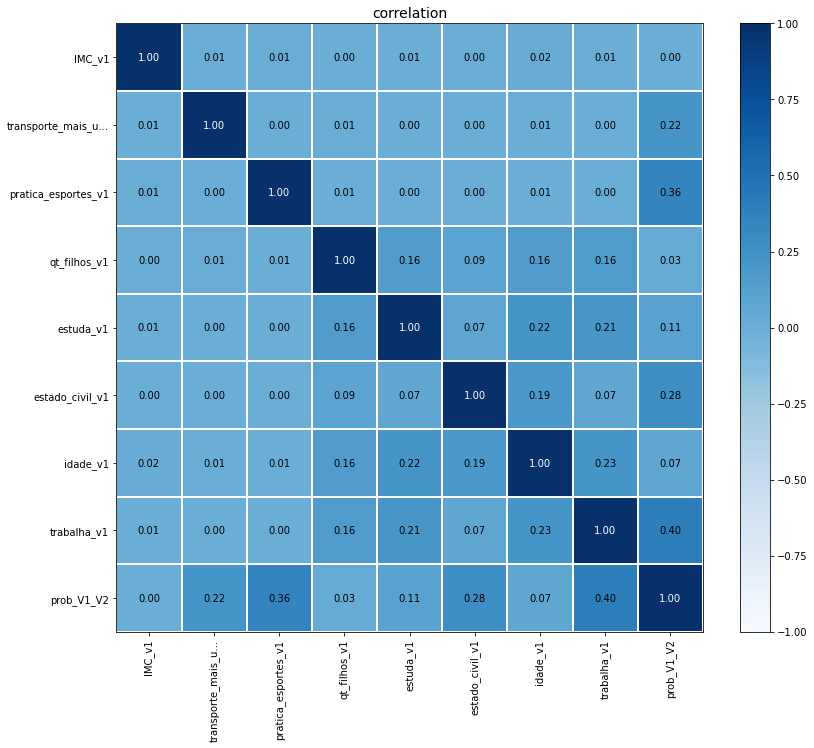

In [23]:
cols = ['prob_V1_V2', 'trabalha_v1','idade_v1', 'estado_civil_v1','estuda_v1','qt_filhos_v1','pratica_esportes_v1','transporte_mais_utilizado_v1','IMC_v1']
tst = df_mix[cols].phik_matrix()
plot_correlation_matrix(tst.values, x_labels=tst.columns, y_labels=tst.index, color_map='Blues',figsize=(12,10.5))

interval columns not set, guessing: ['prob_V1_V2', 'idade_v2', 'qt_filhos_v2', 'IMC_v2']


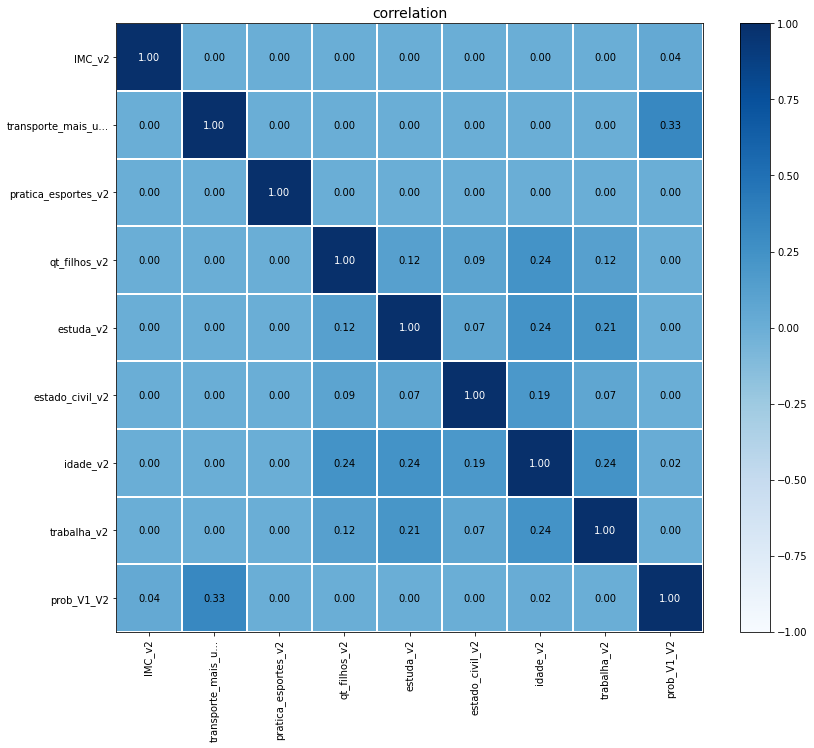

In [24]:
cols = ['prob_V1_V2', 'trabalha_v2','idade_v2', 'estado_civil_v2','estuda_v2','qt_filhos_v2','pratica_esportes_v2','transporte_mais_utilizado_v2','IMC_v2']
tst = df_mix[cols].phik_matrix()
plot_correlation_matrix(tst.values, x_labels=tst.columns, y_labels=tst.index, color_map='Blues',figsize=(12,10.5))

## Taxas de Contaminação:

* Vou considerar taxas acima de 0.5 para analisar.

In [8]:
high = df_mix[df_mix.prob_V1_V2 >= 0.5]
high

V1      V2      grau       proximidade  prob_V1_V2 name_v1  \
0            1       2  trabalho  visita_frequente    0.589462       1   
1            1       3  trabalho       visita_rara    0.708465       1   
3            2       5  trabalho       visita_rara    0.638842       2   
5            3       7   familia     visita_casual    0.709608       3   
8            5      10  trabalho  visita_frequente    0.658706       5   
...        ...     ...       ...               ...         ...     ...   
999970  499986  999972    amigos        mora_junto    0.569828  499986   
999976  499989  999978   familia     visita_casual    0.688603  499989   
999984  499993  999986  trabalho     visita_casual    0.603042  499993   
999985  499993  999987   familia     visita_casual    0.629917  499993   
999991  499996  999993  trabalho     visita_casual    0.621816  499996   

        idade_v1 estado_civil_v1  qt_filhos_v1 estuda_v1 trabalha_v1  \
0           44.0      divorciado           1.0       1.0         0.0   
1           44.0      divorciado           1.0       1.0         0.0   
3           24.0          casado           0.0       0.0         0.0   
5           35.0        solteiro           1.0       0.0         0.0   
8           30.0        solteiro           2.0       1.0         0.0   
...          ...             ...           ...       ...         ...   
999970      28.0      divorciado           0.0       1.0         1.0   
999976      23.0        solteiro           0.0       1.0         0.0   
999984      47.0          casado           1.0       0.0         1.0   
999985      47.0          casado           1.0       0.0         1.0   
999991      16.0        solteiro           3.0       1.0         0.0   

       pratica_esportes_v1 transporte_mais_utilizado_v1     IMC_v1 name_v2  \
0                      1.0                      publico  22.200956       2   
1                      1.0                      publico  22.200956       3   
3                      1.0                      publico  25.378720       5   
5                      1.0                   particular  19.952393       7   
8                      1.0                      publico  15.295668      10   
...                    ...                          ...        ...     ...   
999970                 nan                   particular  35.288593  999972   
999976                 1.0                   particular  19.579020  999978   
999984                 1.0                      publico  31.921363  999986   
999985                 1.0                      publico  31.921363  999987   
999991                 0.0                      publico  26.053920  999993   

        idade_v2 estado_civil_v2  qt_filhos_v2 estuda_v2 trabalha_v2  \
0           24.0          casado           0.0       0.0         0.0   
1           35.0        solteiro           1.0       0.0         0.0   
3           30.0        solteiro           2.0       1.0         0.0   
5           55.0        solteiro           1.0       1.0         1.0   
8           24.0      divorciado           0.0       0.0         0.0   
...          ...             ...           ...       ...         ...   
999970      44.0        solteiro           1.0       0.0         0.0   
999976      40.0          casado           0.0       0.0         1.0   
999984      28.0          casado           1.0       1.0         1.0   
999985       NaN        solteiro           1.0       1.0         1.0   
999991      66.0      divorciado           1.0       0.0         1.0   

       pratica_esportes_v2 transporte_mais_utilizado_v2     IMC_v2  
0                      1.0                      publico  25.378720  
1                      1.0                   particular  19.952393  
3                      1.0                      publico  15.295668  
5                      1.0                   particular        NaN  
8                      1.0                      publico  26.866953  
...                    ...                

<AxesSubplot:xlabel='grau', ylabel='Count'>

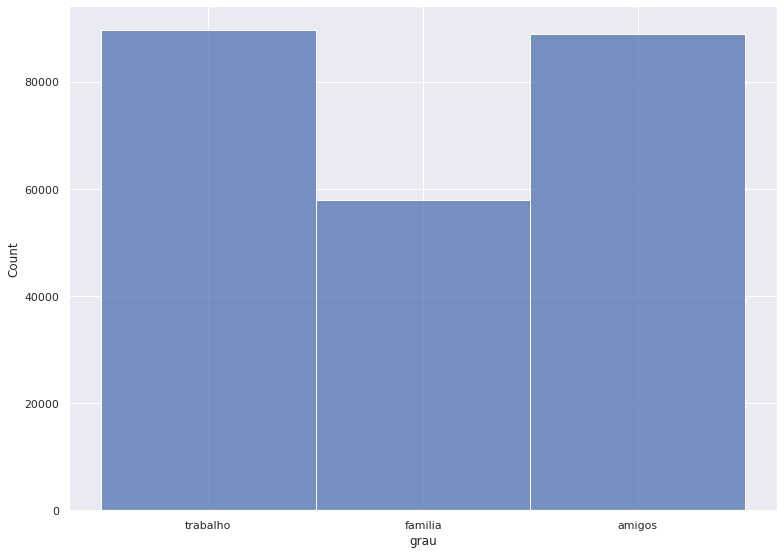

In [44]:
sns.histplot(high.grau)

In [9]:
pf_high = ProfileReport(high, minimal=True)
pf_high

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

interval columns not set, guessing: ['prob_V1_V2', 'idade_v1', 'qt_filhos_v1', 'IMC_v1']


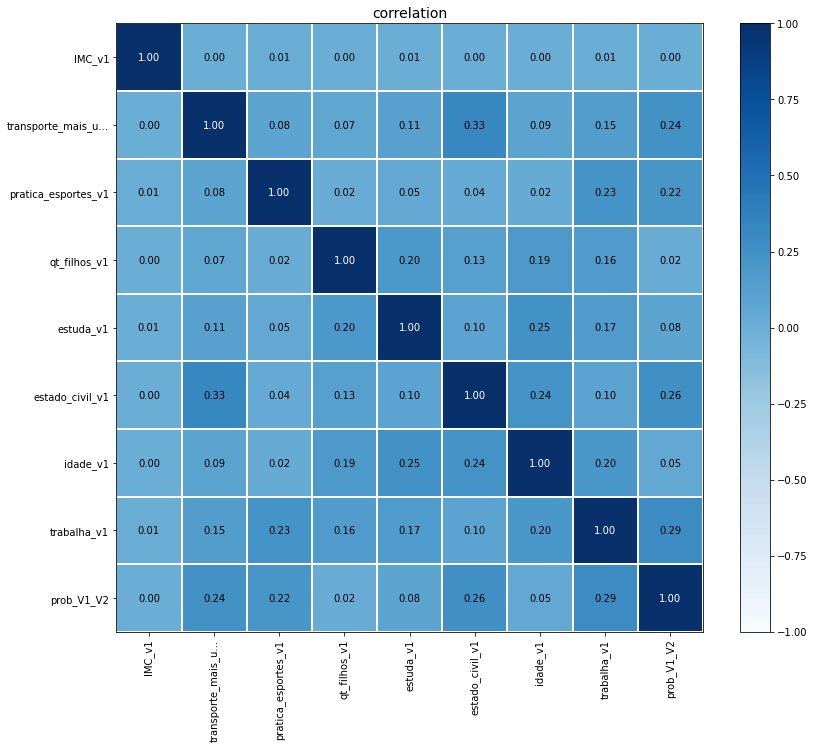

In [26]:
cols = ['prob_V1_V2', 'trabalha_v1','idade_v1', 'estado_civil_v1','estuda_v1','qt_filhos_v1','pratica_esportes_v1','transporte_mais_utilizado_v1','IMC_v1']
tst = high[cols].phik_matrix()
plot_correlation_matrix(tst.values, x_labels=tst.columns, y_labels=tst.index, color_map='Blues',figsize=(12,10.5))

interval columns not set, guessing: ['prob_V1_V2', 'idade_v2', 'qt_filhos_v2', 'IMC_v2']


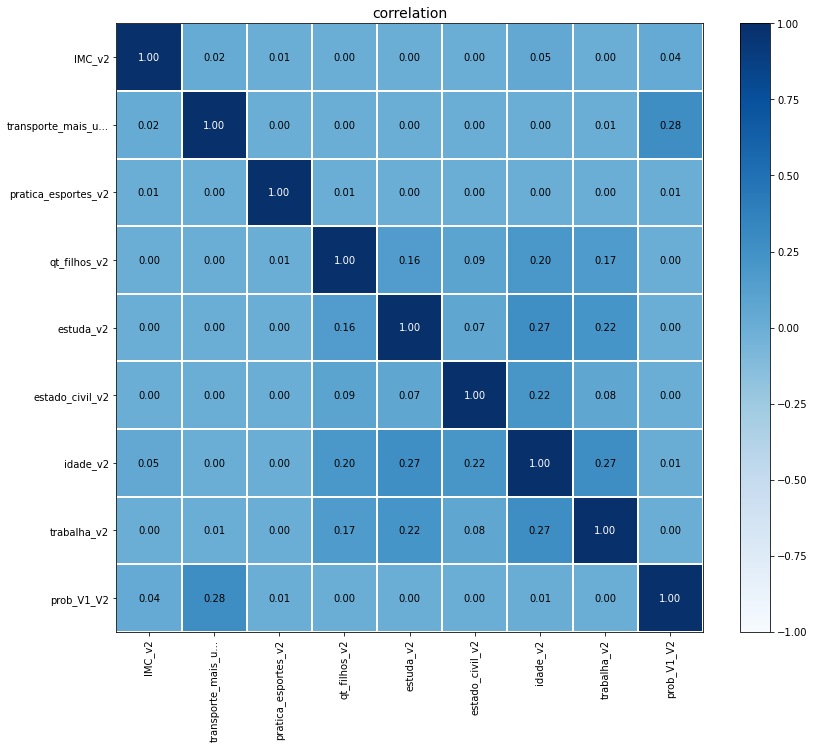

In [27]:
cols = ['prob_V1_V2', 'trabalha_v2','idade_v2', 'estado_civil_v2','estuda_v2','qt_filhos_v2','pratica_esportes_v2','transporte_mais_utilizado_v2','IMC_v2']
tst = high[cols].phik_matrix()
plot_correlation_matrix(tst.values, x_labels=tst.columns, y_labels=tst.index, color_map='Blues',figsize=(12,10.5))